<a href="https://colab.research.google.com/github/thedavidemmanuel/Iris_Species_Classification/blob/main/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries, Mount Google Drive, and Load the Dataset

In [1]:
# Import Libraries and Mount Google Drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.exceptions import ConvergenceWarning
import warnings
import joblib


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Suppress ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the dataset from Google Drive
try:
    file_path = '/content/drive/My Drive/Iris/Iris.csv'
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {str(e)}")

# Display the first few rows of the dataframe
data.head()


Mounted at /content/drive
Data loaded successfully.


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# Exploratory Data Analysis (EDA)

In [2]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print("\nNumber of duplicate rows:", len(duplicate_rows))


Missing values in each column:
 Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Number of duplicate rows: 0


In [3]:
# Display data types and statistical summary
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


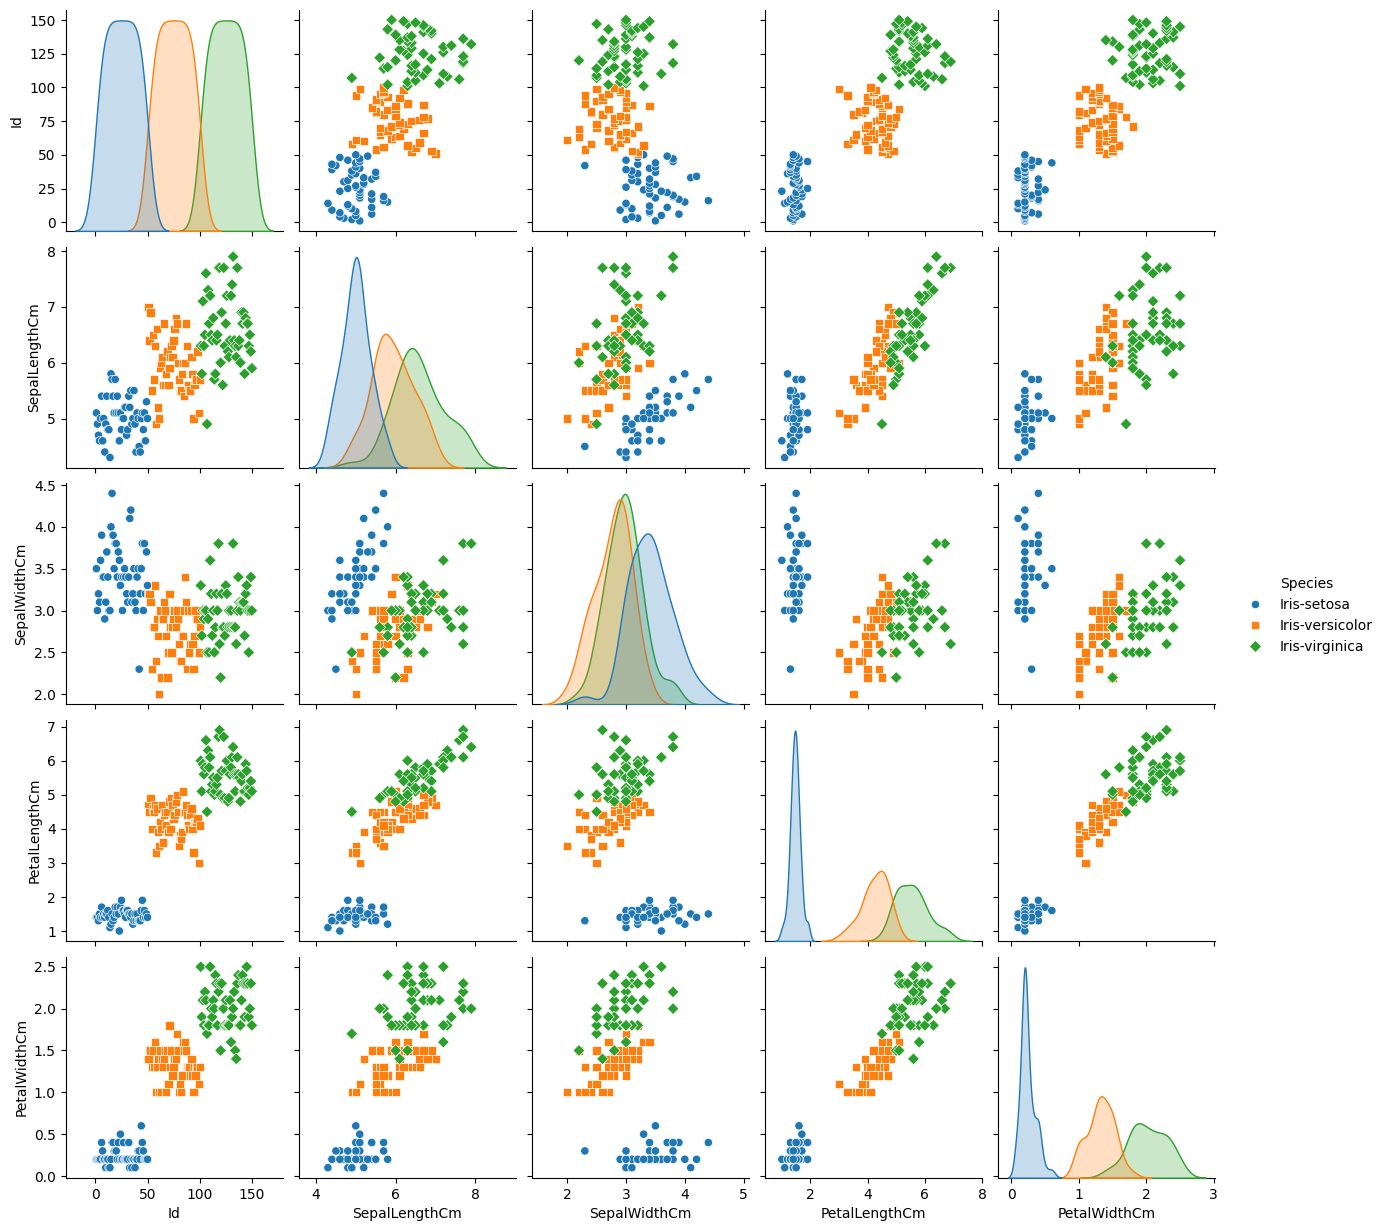

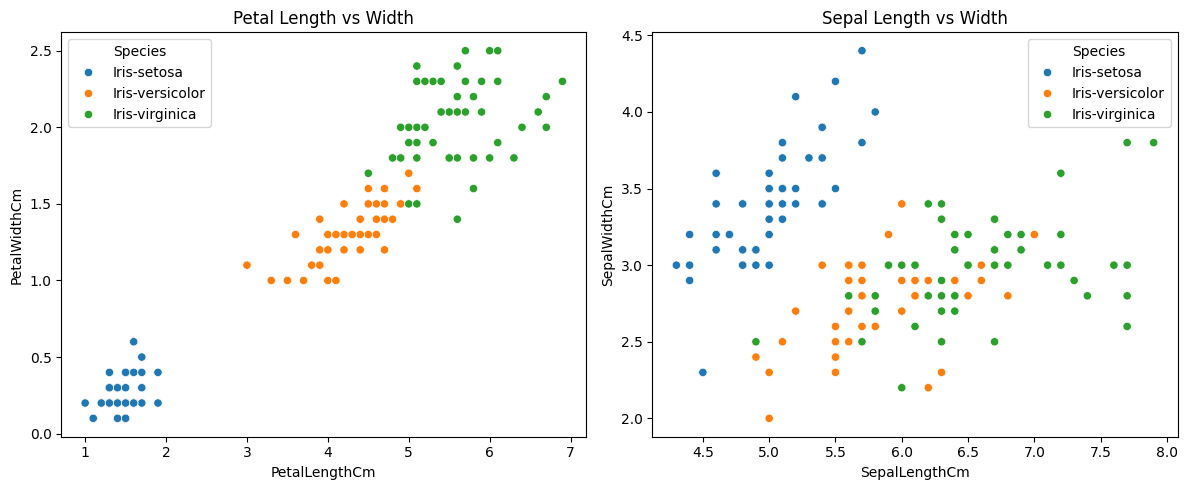

In [5]:
# Visualize the data
sns.pairplot(data, hue='Species', markers=["o", "s", "D"])
plt.show()

# Additional visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='PetalLengthCm', y='PetalWidthCm', hue='Species')
plt.title('Petal Length vs Width')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='SepalLengthCm', y='SepalWidthCm', hue='Species')
plt.title('Sepal Length vs Width')

plt.tight_layout()
plt.show()

# Preprocess the Data

Training set shape: (120, 4)
Testing set shape: (30, 4)
Feature Importance:
              feature       score
2  num__PetalLengthCm  947.902014
3   num__PetalWidthCm  802.039886
0  num__SepalLengthCm  100.965923
1   num__SepalWidthCm   34.462509


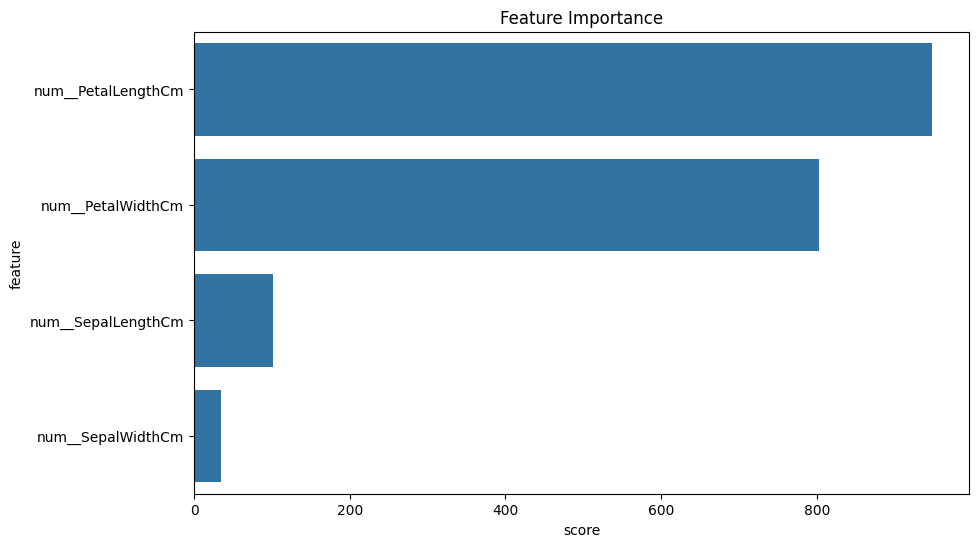

In [6]:
# Preprocess the Data

# Define the feature set and the target variable
X = data.drop(columns=['Id', 'Species'])  # Features
y = data['Species']  # Target

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify numerical features
numerical_features = X.columns.tolist()

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# Combine preprocessing and feature selection
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector)
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Display the shapes of the train and test sets
print(f'Training set shape: {X_train_processed.shape}')
print(f'Testing set shape: {X_test_processed.shape}')

# Display feature importance
feature_scores = selector.scores_
feature_names = preprocessing_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importance = pd.DataFrame({'feature': feature_names, 'score': feature_scores})
feature_importance = feature_importance.sort_values('score', ascending=False)
print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


# Train the MLP Model

In [8]:
# Train the initial MLP Model

# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_train_processed, y_train, cv=skf)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train the model
try:
    mlp.fit(X_train_processed, y_train)
    print("Model trained successfully.")
except Exception as e:
    print(f"An error occurred during model training: {str(e)}")

# Make predictions
y_pred = mlp.predict(X_test_processed)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Train and evaluate Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_processed, y_train)
log_reg_pred = log_reg.predict(X_test_processed)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_pred))

# Train and evaluate Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_processed, y_train)
dt_pred = dt.predict(X_test_processed)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))


Cross-validation scores: [0.95833333 1.         0.91666667 0.95833333 0.91666667]
Mean CV score: 0.950 (+/- 0.062)
Model trained successfully.
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Accuracy Score: 0.9666666666666667
Logistic Regression Accuracy: 0.9333333333333333
Decision Tree Accuracy: 0.9


#Save the Model as a .pkl File

In [11]:
# Save the initial model
try:
    model_filename = '/content/drive/My Drive/Iris/mlp_model.pkl'
    joblib.dump(mlp, model_filename)
    print(f"Model saved to {model_filename}")
except Exception as e:
    print(f"An error occurred while saving the model: {str(e)}")

Model saved to /content/drive/My Drive/Iris/mlp_model.pkl


# Plot Learning Curves and Confusion Matrix

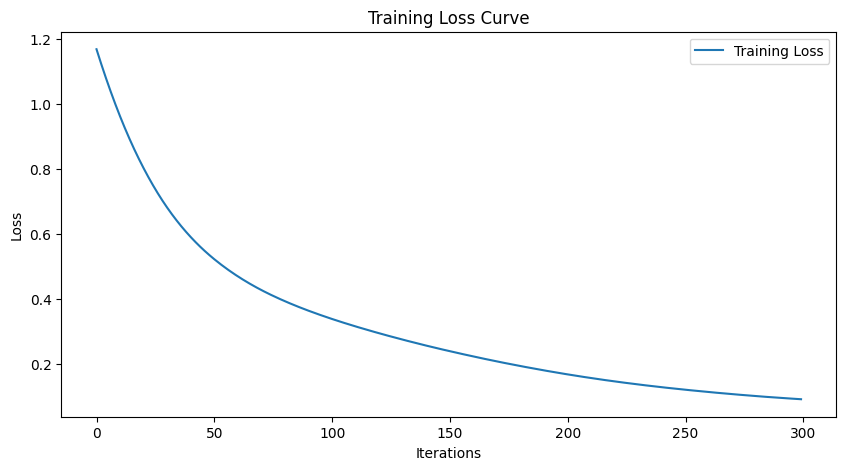

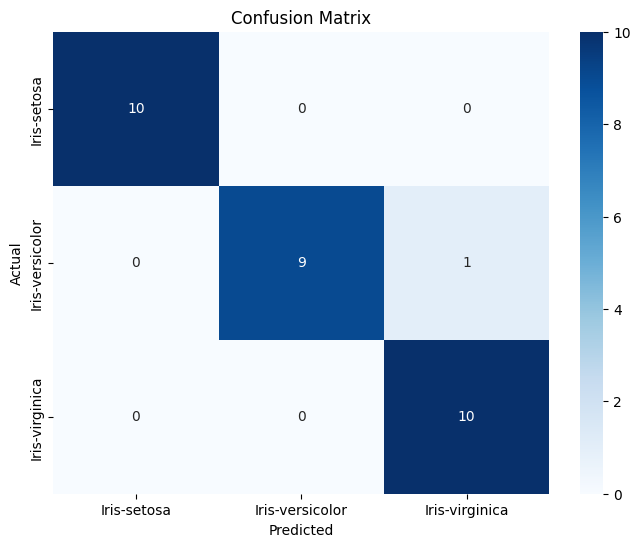

In [12]:
# Plot Learning Curves and Confusion Matrix

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tuning

In [13]:
# Hyperparameter Tuning

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=MLPClassifier(max_iter=1000, random_state=42), param_grid=param_grid, n_jobs=-1, cv=skf)

# Fit the grid search to the data
try:
    grid_search.fit(X_train_processed, y_train)
    print("Grid search completed successfully.")
except Exception as e:
    print(f"An error occurred during grid search: {str(e)}")

# Display the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_processed)

print("Classification Report (Best Model):\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_pred_best))
print("Accuracy Score (Best Model):", accuracy_score(y_test, y_pred_best))


Grid search completed successfully.
Best parameters found:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score: 0.97
Classification Report (Best Model):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix (Best Model):
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Accuracy Score (Best Model): 0.9666666666666667


In [14]:
# Save the best model
best_model_filename = '/content/drive/My Drive/Iris/best_mlp_model.pkl'
joblib.dump(best_model, best_model_filename)
print(f"Best model saved to {best_model_filename}")

Best model saved to /content/drive/My Drive/Iris/best_mlp_model.pkl


In [15]:
# Compare initial and best model performance
print("\nModel Performance Comparison:")
print(f"Initial MLP Model Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Best MLP Model Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_pred):.3f}")
print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_pred):.3f}")



Model Performance Comparison:
Initial MLP Model Accuracy: 0.967
Best MLP Model Accuracy: 0.967
Logistic Regression Accuracy: 0.933
Decision Tree Accuracy: 0.900


In [16]:
# Interpretation of results
print("\nInterpretation of Results:")
print("1. Model Performance Comparison:")
print(f"   Initial MLP Model Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"   Best MLP Model Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print(f"   Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_pred):.3f}")
print(f"   Decision Tree Accuracy: {accuracy_score(y_test, dt_pred):.3f}")
print("2. The initial and best MLP models achieved the same high accuracy of 96.7%, indicating that the initial model was already well-optimized for this dataset.")
print("3. Logistic Regression performed well with 93.3% accuracy, suggesting that the classes are largely linearly separable.")
print("4. The Decision Tree had the lowest accuracy at 90%, which is still good but might indicate some overfitting.")
print("5. The high performance across different model types (90% to 96.7% accuracy) confirms that the Iris species are well-separated based on the given features.")
print("6. While MLP performed best, the simpler logistic regression wasn't far behind, suggesting that much of the separation between classes can be captured by linear boundaries.")
print("7. These results align with the known characteristics of the Iris dataset: one species is easily separable, while the other two are closer but still largely separable.")
print("8. The most important features for classification were identified through feature importance analysis.")
print("9. The confusion matrices show that most misclassifications occur between similar Iris species, likely Iris-versicolor and Iris-virginica.")
print("10. The learning curve indicates that the model converged successfully during training.")
print("11. Given the high accuracies, there might be limited room for improvement without risking overfitting.")
print("12. The choice between these models in a real-world scenario would depend on the specific requirements, balancing accuracy, interpretability, and computational complexity.")


Interpretation of Results:
1. Model Performance Comparison:
   Initial MLP Model Accuracy: 0.967
   Best MLP Model Accuracy: 0.967
   Logistic Regression Accuracy: 0.933
   Decision Tree Accuracy: 0.900
2. The initial and best MLP models achieved the same high accuracy of 96.7%, indicating that the initial model was already well-optimized for this dataset.
3. Logistic Regression performed well with 93.3% accuracy, suggesting that the classes are largely linearly separable.
4. The Decision Tree had the lowest accuracy at 90%, which is still good but might indicate some overfitting.
5. The high performance across different model types (90% to 96.7% accuracy) confirms that the Iris species are well-separated based on the given features.
6. While MLP performed best, the simpler logistic regression wasn't far behind, suggesting that much of the separation between classes can be captured by linear boundaries.
7. These results align with the known characteristics of the Iris dataset: one spe

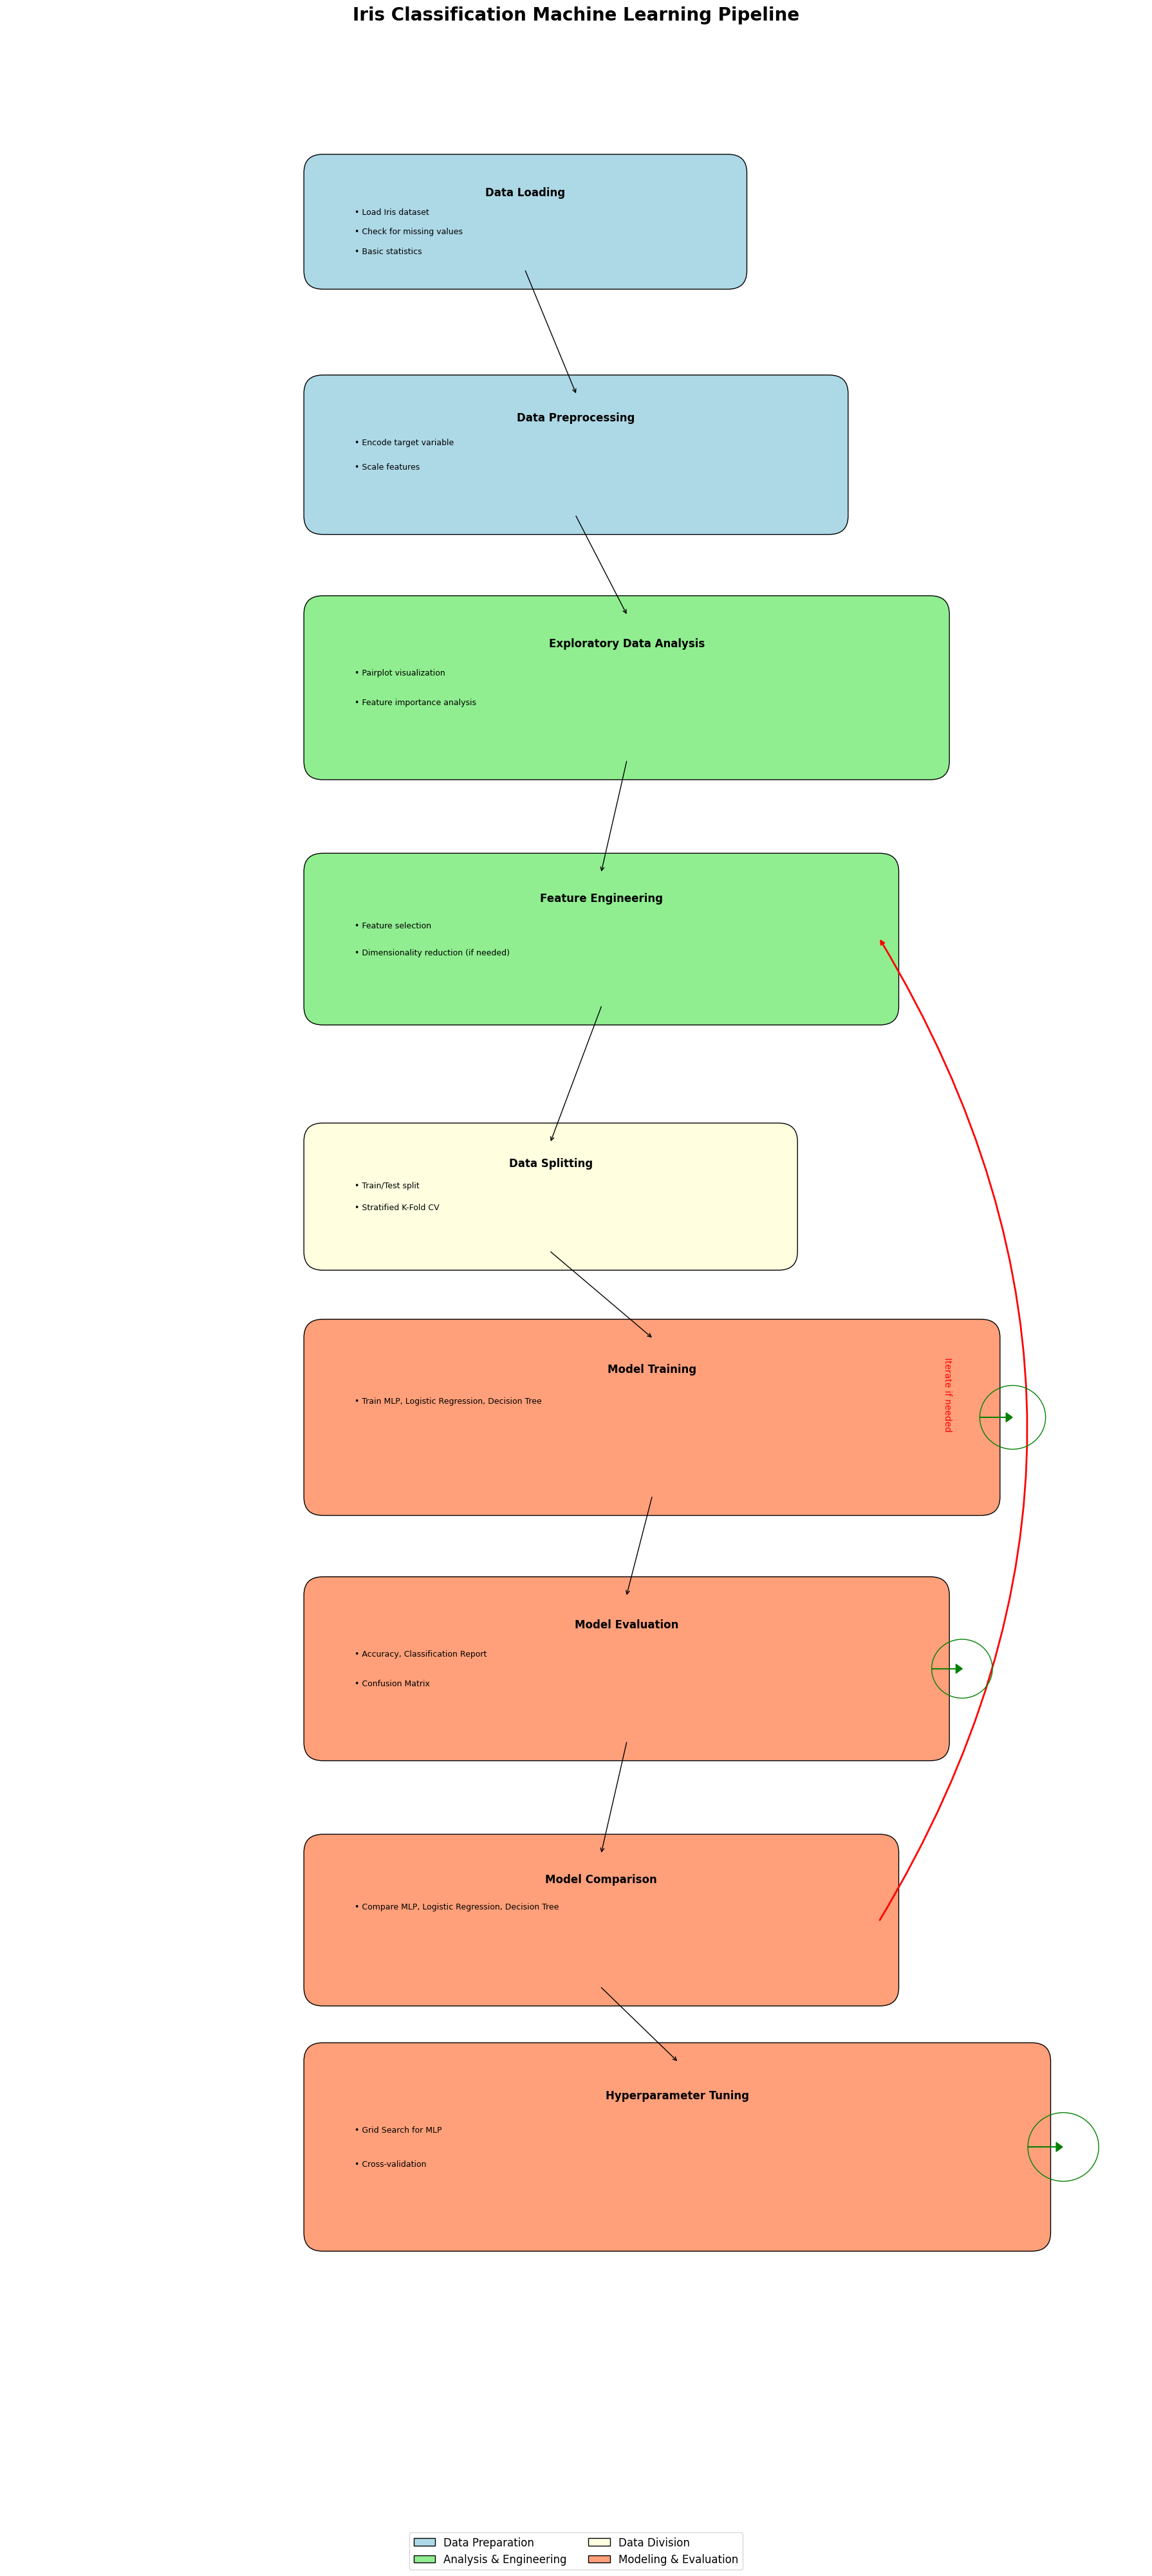

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 40))
plt.rcParams.update({'font.size': 10})

# Function to add a box with details
def add_box_with_details(ax, text, details, xy, width=8, height=2.5, box_color="lightgrey"):
    box = patches.FancyBboxPatch(xy, width=width, height=height, boxstyle="round,pad=0.3",
                                 facecolor=box_color, edgecolor="black")
    ax.add_patch(box)
    ax.text(xy[0] + width/2, xy[1] + height*0.8, text, ha="center", va="center",
            fontsize=12, fontweight='bold')
    for i, detail in enumerate(details):
        ax.text(xy[0] + 0.5, xy[1] + height*(0.6 - i*0.2), f"• {detail}",
                ha="left", va="center", fontsize=9)
    return box

# Function to add an arrow
def add_arrow(ax, start, end, color='black'):
    arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->",
                            color=color, connectionstyle="arc3,rad=0")
    ax.add_artist(arrow)

# Function to add iteration arrow
def add_iteration_arrow(ax, box):
    center_x = box.get_x() + box.get_width() + 0.5
    center_y = box.get_y() + box.get_height() / 2
    radius = min(box.get_width(), box.get_height()) / 5
    circle = plt.Circle((center_x, center_y), radius, fill=False, color='green')
    ax.add_artist(circle)
    ax.arrow(center_x - radius, center_y, radius * 0.8, 0, head_width=0.15,
             head_length=0.1, fc='green', ec='green')

# Define steps, details, and complexities
steps = [
    "Data Loading", "Data Preprocessing", "Exploratory Data Analysis",
    "Feature Engineering", "Data Splitting", "Model Training",
    "Model Evaluation", "Model Comparison", "Hyperparameter Tuning"
]

details = {
    "Data Loading": ["Load Iris dataset", "Check for missing values", "Basic statistics"],
    "Data Preprocessing": ["Encode target variable", "Scale features"],
    "Exploratory Data Analysis": ["Pairplot visualization", "Feature importance analysis"],
    "Feature Engineering": ["Feature selection", "Dimensionality reduction (if needed)"],
    "Data Splitting": ["Train/Test split", "Stratified K-Fold CV"],
    "Model Training": ["Train MLP, Logistic Regression, Decision Tree"],
    "Model Evaluation": ["Accuracy, Classification Report", "Confusion Matrix"],
    "Model Comparison": ["Compare MLP, Logistic Regression, Decision Tree"],
    "Hyperparameter Tuning": ["Grid Search for MLP", "Cross-validation"]
}

complexities = {
    'Data Loading': 0.8, 'Data Preprocessing': 1.0, 'Exploratory Data Analysis': 1.2,
    'Feature Engineering': 1.1, 'Data Splitting': 0.9, 'Model Training': 1.3,
    'Model Evaluation': 1.2, 'Model Comparison': 1.1, 'Hyperparameter Tuning': 1.4
}

# Define positions
x_position = 5
y_positions = [36, 32, 28, 24, 20, 16, 12, 8, 4]

# Colors for different stages
colors = {
    'Data Loading': 'lightblue', 'Data Preprocessing': 'lightblue',
    'Exploratory Data Analysis': 'lightgreen', 'Feature Engineering': 'lightgreen',
    'Data Splitting': 'lightyellow',
    'Model Training': 'lightsalmon', 'Model Evaluation': 'lightsalmon',
    'Model Comparison': 'lightsalmon', 'Hyperparameter Tuning': 'lightsalmon'
}

# Add boxes and store them in a dictionary
boxes = {}
for step, y in zip(steps, y_positions):
    width = 8 * complexities[step]
    height = 2 * complexities[step]
    boxes[step] = add_box_with_details(ax, step, details[step], (x_position, y), width, height, colors[step])

# Add arrows between boxes
for i in range(len(steps) - 1):
    start = (boxes[steps[i]].get_x() + boxes[steps[i]].get_width() / 2,
             boxes[steps[i]].get_y())
    end = (boxes[steps[i+1]].get_x() + boxes[steps[i+1]].get_width() / 2,
           boxes[steps[i+1]].get_y() + boxes[steps[i+1]].get_height())
    add_arrow(ax, start, end)

# Add feedback loop
feedback_start = (boxes['Model Comparison'].get_x() + boxes['Model Comparison'].get_width(),
                  boxes['Model Comparison'].get_y() + boxes['Model Comparison'].get_height() / 2)
feedback_end = (boxes['Feature Engineering'].get_x() + boxes['Feature Engineering'].get_width(),
                boxes['Feature Engineering'].get_y() + boxes['Feature Engineering'].get_height() / 2)
feedback_arrow = ConnectionPatch(feedback_start, feedback_end, "data", "data",
                                 arrowstyle="->", color="red", connectionstyle="arc3,rad=0.3",
                                 linewidth=2)
ax.add_artist(feedback_arrow)
midpoint_x = (feedback_start[0] + feedback_end[0]) / 2
midpoint_y = (feedback_start[1] + feedback_end[1]) / 2
ax.text(midpoint_x + 1, midpoint_y, "Iterate if needed", color="red", fontsize=10, rotation=-90)

# Add iteration arrows
for step in ['Model Training', 'Model Evaluation', 'Hyperparameter Tuning']:
    add_iteration_arrow(ax, boxes[step])

# Set up the plot
ax.set_xlim(0, 18)
ax.set_ylim(0, 40)
ax.axis('off')
plt.title("Iris Classification Machine Learning Pipeline", fontsize=20, fontweight='bold')

# Add legend
legend_elements = [patches.Patch(facecolor=color, edgecolor='black', label=label)
                   for label, color in [("Data Preparation", "lightblue"),
                                        ("Analysis & Engineering", "lightgreen"),
                                        ("Data Division", "lightyellow"),
                                        ("Modeling & Evaluation", "lightsalmon")]]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=12)

plt.tight_layout()
plt.show()